# 개발 환경

- WorkSpace: Google Colab
  - OS: Ubuntu 22.04.2 LTS
  - System RAM: 51.0 GB
  - GPU(V100) RAM: 16.0 GB
- Python Version: Python 3.10.12
- ML/DL FrameWork: Torch 2.0.1+cu118

- 데이터 입출력 경로 정의:
  - `./data/`: 모든 `.csv` 파일
  - `./model/`: 학습된 모델 `.pth` 파일
  - `./submit/`: 예측 결과 submission 파일

- 학습된 모델 다운로드 링크: https://drive.google.com/file/d/1CUvN0z31y-q1YNRQ70ZkGRZiJPn6a1uw/view?usp=sharing
  - 다운로드 후 `./model/` 폴더에 `best_model.pth` 이름으로 넣어주세요.

- 사용한 라이브러리 버전

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


# 사전 설정

## 구글 드라이브 Mount (Only use in Google Colab)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/lg_aimers

In [2]:
# %cd /content/drive/MyDrive/dacon/lgaimers-3

/content/drive/MyDrive/dacon/lgaimers-3


## Library 호출 및 Device 설정

In [3]:
import random
import gc
import os
import math
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Config 및 Seed 값 고정

In [5]:
# 구축 전에 사용할 config 변수 설정

class CFG:
  TRAIN_WINDOW_SIZE = 126
  PREDICT_SIZE = 21
  EPOCHS = 10
  LEARNING_RATE = 1e-4
  BATCH_SIZE = 256
  SEED = 41

# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

# Warning 출력 무시
np.seterr(divide='ignore', invalid='ignore')

# 데이터 분석

**수행 방법**
  - 범주 데이터 (대분류, 중분류, 소분류, 브랜드) 특징 분석
  - 분석 시, StandardScaler를 통해 Scale을 맞추고 수행
  - 차트에 단순 이동 평균 (MA, window==25)를 적용해서 뚜렷한 변화량을 파악

**결과**
  - 각 범주 데이터들의 상관 관계

In [ ]:
train_data = pd.read_csv('./data/train.csv').drop(columns=['ID'])

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

train_data.iloc[:, 5:] = sc.fit_transform(train_data.iloc[:,5:].values.T).T

In [ ]:
from sklearn.preprocessing import Normalizer

sc = Normalizer()

train_data.iloc[:, 5:] = sc.fit_transform(train_data.iloc[:,5:].values)

In [ ]:
# 대분류를 기준으로 그룹화하여 개수를 합산
big_grouped = train_data.groupby(["대분류"]).sum().reset_index()

<ipython-input-8-db52398a4f90>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_grouped = train_data.groupby(["대분류"]).sum().reset_index()


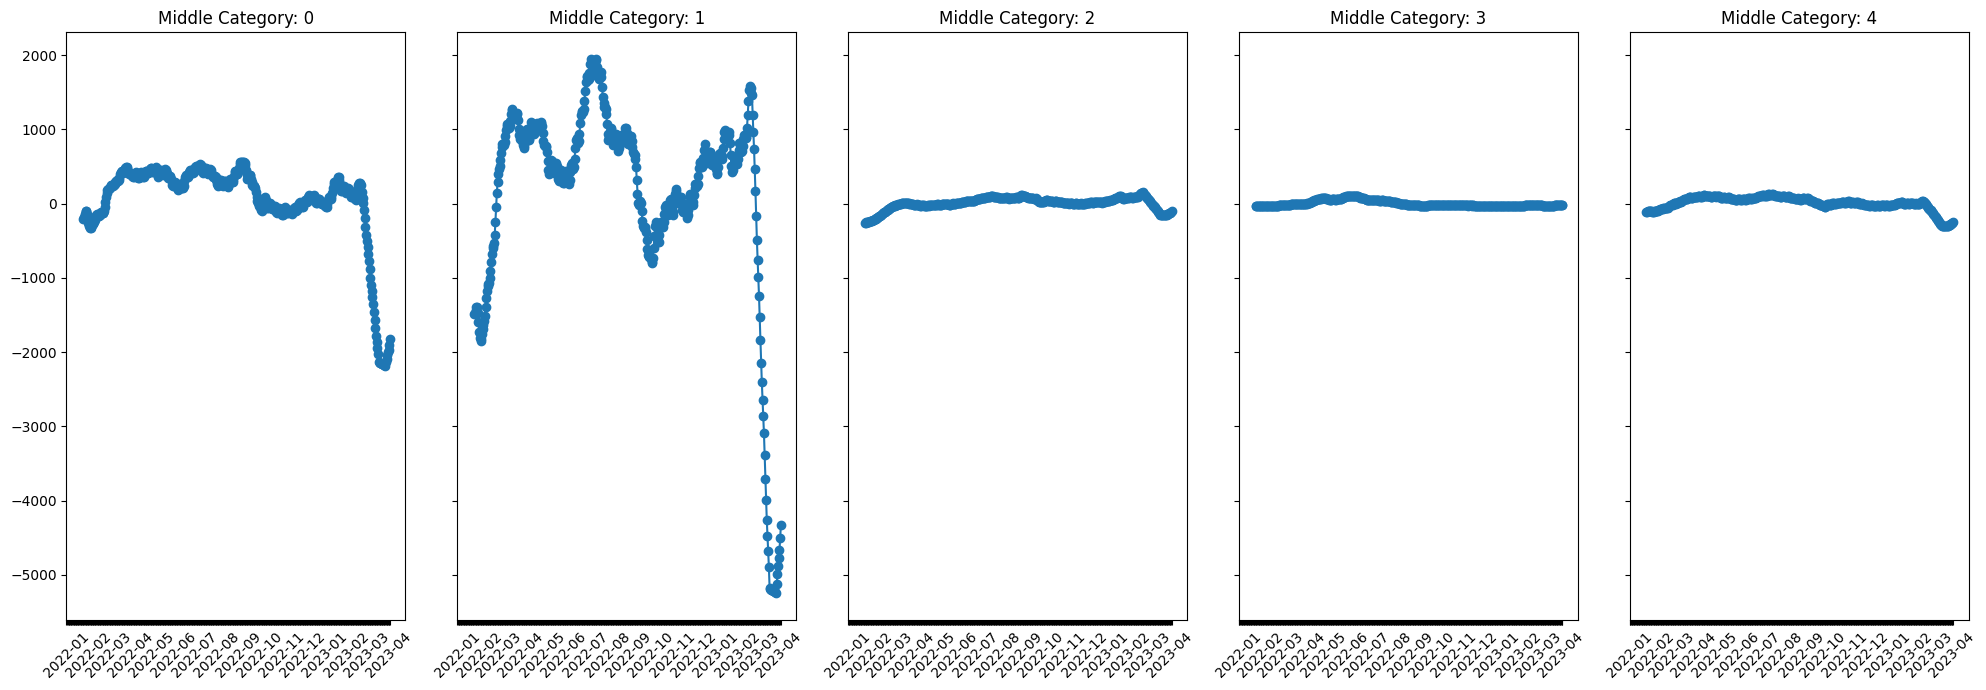

In [ ]:
date_columns = big_grouped.columns[1:]  # 첫 번째 열은 대분류이므로 제외

# 그래프를 한번에 그릴 그림 설정
fig, axs = plt.subplots(1, 5, figsize=(20, 7), sharey=True)

# 대분류별로 데이터를 선택하여 그래프 그리기
for idx, middle_category in enumerate(big_grouped.index):
    data = big_grouped.loc[middle_category, date_columns]
    data = data.rolling(window=25).mean()

    axs[idx].plot(data.index, data.values, marker='o')
    axs[idx].set_title(f'Middle Category: {middle_category}')

    # 월별로 x축 레이블 설정
    x_labels = [date[:-3] if int(date[-2:]) == 1 else '' for date in data.index]
    axs[idx].set_xticks(data.index)
    axs[idx].set_xticklabels(x_labels, rotation=45)

# 그래프 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
# 중분류를 기준으로 그룹화하여 개수를 합산
middle_grouped = train_data.groupby(["중분류"]).sum().reset_index()

<ipython-input-133-614964d25dd2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  middle_grouped = train_data.groupby(["중분류"]).sum().reset_index()


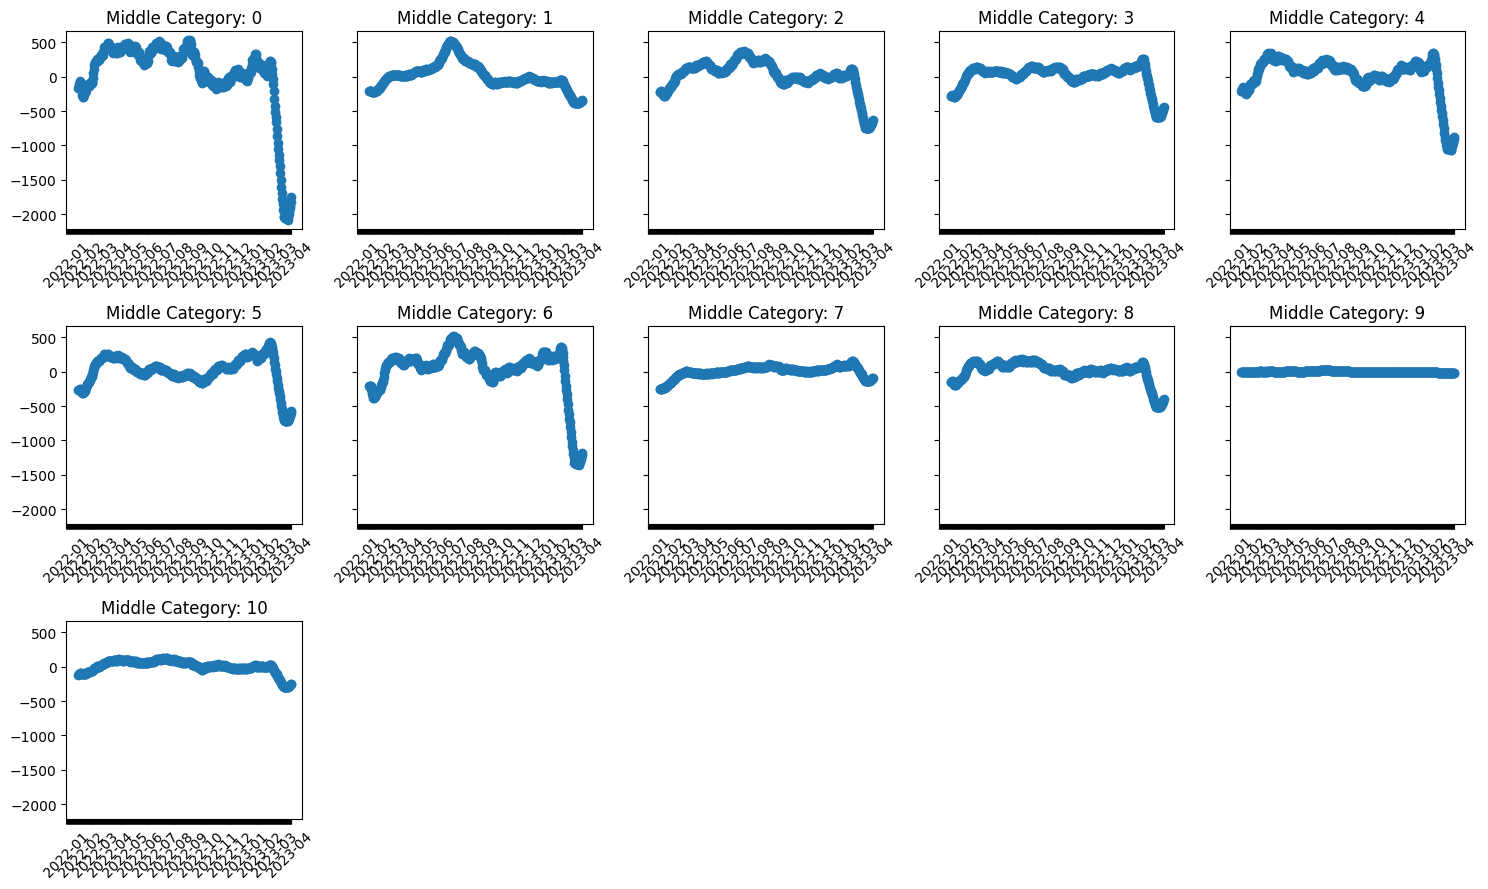

In [ ]:
import matplotlib.pyplot as plt
date_columns = middle_grouped.columns[1:]  # 첫 번째 열은 대분류이므로 제외

# 그래프를 한번에 그릴 그림 설정
num_rows = (len(middle_grouped) + 4) // 5  # 5개씩 그래프를 그리기 위한 행 개수 계산
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3), sharey=True)

# 중분류별로 데이터를 선택하여 그래프 그리기
for idx, middle_category in enumerate(middle_grouped.index):
    row = idx // 5
    col = idx % 5
    ax = axs[row, col]

    data = middle_grouped.loc[middle_category, date_columns]
    data = data.rolling(window=25).mean()
    ax.plot(data.index, data.values, marker='o')
    ax.set_title(f'Middle Category: {middle_category}')

    # 월별로 x축 레이블 설정
    x_labels = [date[:-3] if int(date[-2:]) == 1 else '' for date in data.index]
    ax.set_xticks(data.index)
    ax.set_xticklabels(x_labels, rotation=45)

# 빈 그래프 삭제
while idx + 1 < num_rows * 5:
    row = idx // 5
    col = (idx + 1) % 5
    axs[row, col].remove()
    idx += 1

# 그래프 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
# 소분류와 기준으로 그룹화하여 개수를 합산
small_grouped = train_data.groupby(["소분류"]).sum().reset_index()

<ipython-input-135-ee478c7a0fda>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  small_grouped = train_data.groupby(["소분류"]).sum().reset_index()


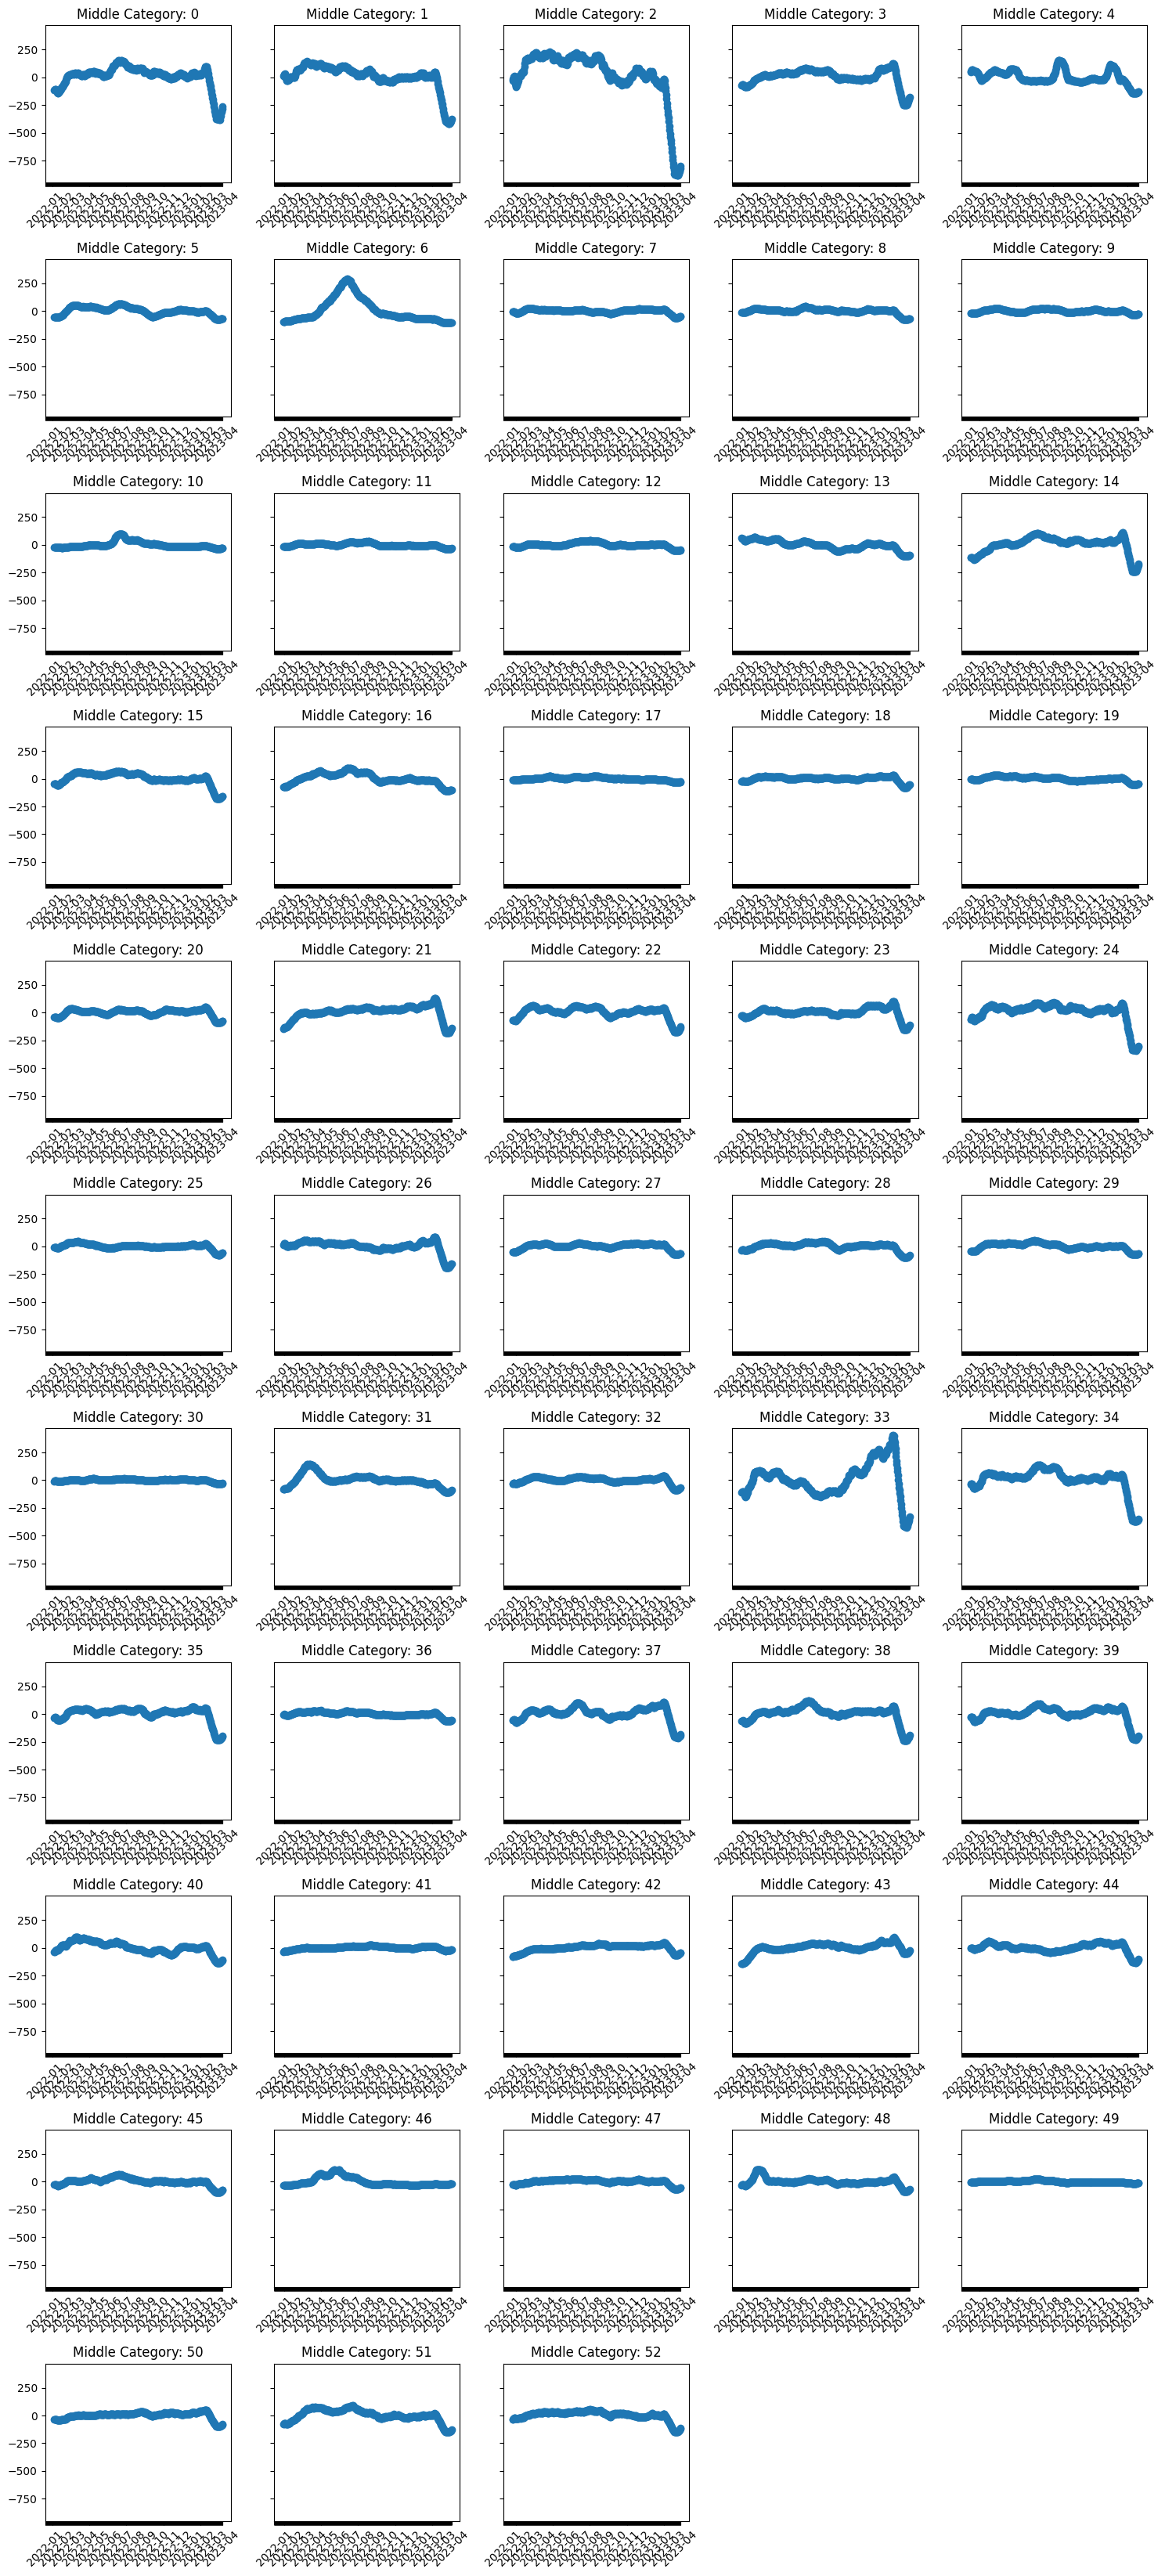

In [ ]:
date_columns = small_grouped.columns[1:]  # 첫 번째 열은 대분류이므로 제외

# 그래프를 한번에 그릴 그림 설정
num_rows = (len(small_grouped) + 4) // 5  # 5개씩 그래프를 그리기 위한 행 개수 계산
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3), sharey=True)

# 소분류별로 데이터를 선택하여 그래프 그리기
for idx, middle_category in enumerate(small_grouped.index):
    row = idx // 5
    col = idx % 5
    ax = axs[row, col]

    data = small_grouped.loc[middle_category, date_columns]
    data = data.rolling(window=25).mean()
    ax.plot(data.index, data.values, marker='o')
    ax.set_title(f'Middle Category: {middle_category}')

    # 월별로 x축 레이블 설정
    x_labels = [date[:-3] if int(date[-2:]) == 1 else '' for date in data.index]
    ax.set_xticks(data.index)
    ax.set_xticklabels(x_labels, rotation=45)

# 빈 그래프 삭제
while idx + 1 < num_rows * 5:
    row = idx // 5
    col = (idx + 1) % 5
    axs[row, col].remove()
    idx += 1

# 그래프 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
# 브랜드를 기준으로 그룹화하여 개수를 합산
brand_grouped = train_data.groupby(["브랜드"]).sum().reset_index()

<ipython-input-155-d24687197968>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  brand_grouped = train_data.groupby(["브랜드"]).sum().reset_index()


In [ ]:
# 날짜 열 선택
date_columns = brand_grouped.columns[1:]

# 그래프를 한번에 그릴 그림 설정
num_middle_categories = len(brand_grouped)
num_plots_per_page = 10  # 각 페이지에 그릴 subplot 개수
num_pages = (num_middle_categories + num_plots_per_page - 1) // num_plots_per_page

# 페이지별로 그래프 그리기
for page in range(num_pages):
    start_idx = page * num_plots_per_page
    end_idx = min((page + 1) * num_plots_per_page, num_middle_categories)

    fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=True)

    for idx, brand in enumerate(brand_grouped.index[start_idx:end_idx]):
        row = idx // 5
        col = idx % 5
        ax = axs[row, col]

        data = brand_grouped.loc[brand_grouped.index == brand, date_columns].rolling(window=25,axis=1).mean().values.ravel()
        ax.plot(date_columns, data, marker='o')

        # 이 부분이 수정된 부분입니다.
        brand_info = brand_grouped.iloc[brand, 0]  # 0번째 열의 정보 가져오기
        ax.set_title(f'brand: {brand_info}')  # 제목 설정

        # 월별로 x축 레이블 설정
        x_labels = [date[:-3] if int(date[-2:]) == 1 else '' for date in date_columns]
        ax.set_xticks(date_columns)
        ax.set_xticklabels(x_labels, rotation=45)

    # 빈 그래프 삭제
    while idx + 1 < num_plots_per_page:
        row = idx // 5
        col = (idx + 1) % 5
        axs[row, -col].remove()
        idx += 1

    # 그래프 간격 조정
    plt.tight_layout()

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 데이터 정의

## 데이터 전처리

- `train.csv` 뿐만 아니라 `sales.csv` , `brand_keyword_cnt.csv` 데이터도 활용해서 Model의 Input로 활용해서 평가 진행
- **결론부터 말하면 사용 안 하는 모델의 성능이 제일 높게 나왔다.**
- 그래도 평가를 위해 모두 사용해보기
- `sales.csv` 활용법:
  - `train.csv`의 판매량과 `sales.csv`의 판매액을 통해 대략적인 판매 단가를 알 수 있다.
  - 각 행의 판매 단가를 구하고 100자리수로 반올림을 한 값을 `train.csv`의 새로운 범주 데이터로 활용한다.

- `brand_keyword_cnt.csv` 의 활용법:
  - 결측치가 존재하는 데이터이다.
  - 결측치가 포함된 행들 중에서 중요도가 높은(위 데이터 분석 결과 plot 중에서 변화량이 많은 데이터들) 데이터는 평균값, 중요도가 낮은 데이터는 0으로 채웠다.


Sales

In [ ]:
train_data = pd.read_csv('./data/train.csv').drop(columns=['ID','대분류','중분류','소분류','브랜드'])

In [ ]:
sales_data = pd.read_csv('./data/sales.csv').drop(columns=['ID','대분류','중분류','소분류','브랜드'])

In [ ]:
# 각 제품의 가격 추정
estimated_prices = []
for idx, row in sales_data.iterrows():
    corresponding_row = train_data.loc[idx]
    total_price = sum(row[1:])
    total_quantity = sum(corresponding_row[train_data.columns[1:]])
    if total_quantity == 0:
        estimated_prices.append(0)
    else:
        estimated_prices.append(total_price // total_quantity)


In [ ]:
print(estimated_prices)
rounded_prices = [round(price, -2) for price in estimated_prices]
print(rounded_prices)
# 추정된 가격을 train_data에 추가
train_data.insert(1, '가격', rounded_prices)

[5488, 24338, 11750, 4005, 5092, 7650, 7205, 12040, 4787, 14650, 20416, 3893, 64031, 10809, 8633, 31750, 2800, 2609, 5289, 3902, 2545, 3400, 21000, 3890, 1600, 20671, 1100, 2970, 10815, 54900, 11458, 15636, 6312, 23975, 15900, 1403, 1590, 49000, 49666, 3547, 11198, 19000, 22187, 23042, 25900, 18137, 7572, 9549, 14324, 7407, 16855, 4797, 16000, 2000, 1442, 1000, 2000, 5739, 1500, 3900, 4400, 2200, 4400, 36500, 36800, 2679, 5050, 5599, 4025, 4077, 3772, 5357, 1904, 4427, 6922, 39900, 755, 11334, 2800, 2370, 2800, 4980, 2489, 3484, 22400, 22889, 14920, 4483, 32900, 22900, 17900, 29900, 29800, 4460, 1890, 18957, 11000, 1920, 1780, 10670, 61380, 12053, 7164, 3398, 3500, 2486, 4901, 14478, 3600, 4519, 12761, 9013, 7824, 15845, 16328, 12598, 9095, 11796, 13425, 16052, 34009, 6882, 9724, 11644, 5103, 5905, 7280, 9111, 11445, 7937, 39000, 9562, 9300, 18501, 17975, 85996, 73500, 12081, 19800, 23500, 34785, 23988, 34900, 0, 21338, 21669, 25231, 2453, 5774, 20720, 23213, 14939, 37332, 23695, 37107

In [ ]:
# train_data 데이터프레임을 CSV 파일로 저장
train_data.to_csv('./data/new_train_round.csv', index=False)

Brand-Keyword

In [ ]:
file_path = './data/brand_keyword_cnt.csv'

df = pd.read_csv(file_path)

# 평균으로 결측치 값을 처리할 브랜드
data = ["B002-00302", "B002-00460", "B002-00533", "B002-00567", "B002-02020", "B002-02372", "B002-02753", "B002-02989"]

# 0번째 열의 데이터 가져오기
column_sums = df.iloc[:, 1:].sum(axis=0)

column_sums=column_sums/len(df)

# 2차원 배열을 1차원 리스트로 변환
column_sums = [value for value in column_sums.values]

# 결측치가 있는 행의 인덱스 찾기
missing_indices = df[df.isnull().any(axis=1)].index

# 결측치가 있는 행의 데이터를 values_column_0_scal_pos로 채움
for idx in missing_indices:
    brand_value = df.loc[idx, '브랜드']
    if brand_value in data:
        df.loc[idx, '2022-01-01':] = column_sums
    else:
        df.loc[idx, '2022-01-01':] = 0

csv_filename = './data/brand_keyword_cnt_preprocess.csv'
df.to_csv(csv_filename, index=False)

## DataSet, DataLoader 구축

- `train.csv` 파일만 사용
  - 총 4개의 범주 데이터 : [대분류, 중분류, 소분류, 브랜드]
  - 총 1개의 시계열 데이터 : [판매량]

In [6]:
train_data = pd.read_csv('./data/train.csv').drop(columns=['ID','제품'])
cat_size = 4

In [7]:
# 시계열 데이터 스케일링
sc_main = MinMaxScaler()

train_data.iloc[:, cat_size:] = sc_main.fit_transform(train_data.iloc[:,cat_size:].values.T).T

In [8]:
# Label Encoding
# 맨 마지막의 숫자로 Label Encoding

big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

In [9]:
# 띄엄띄엄 넣기
def make_train_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE, STEP_SIZE=7):
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :cat_size]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            # input_data[i * adjusted_size + j] = temp_data
            # target_data[i * adjusted_size + j] = window[train_size:]
            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, target_data

In [10]:
def make_predict_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE):
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :cat_size]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [11]:
train_input, train_target = make_train_data(train_data, cat_size)
test_input = make_predict_data(train_data, cat_size)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [12]:
# Stratified Train Val Split (By 대분류)
# 대분류 기준으로 Train, Valid 데이터가 균등하게 분포하도록

skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(train_input, y=train_input[:,0,1])):
    if i == fold:
        val_input = train_input[val_idxs]
        val_target = train_target[val_idxs]

        train_input = train_input[train_idxs]
        train_target = train_target[train_idxs]
        break

In [20]:
print(train_input.shape, train_target.shape,val_input.shape, val_target.shape)

(572040, 126, 5) (572040, 21) (143010, 126, 5) (143010, 21)


In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [14]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

# 모델 학습

## 모델 클래스 정의
- Time Series Transformer 사용
- 사전 학습 모델은 사용하지 않고 바로 Tuning

In [15]:
# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# Time Series Data Embedding Module
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

# 가우시안 노이즈 레이어 > 과적합 방지를 위해
class GaussianNoiseLayer(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            noisy_x = x + noise
            return noisy_x
        return x

In [16]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_time_steps, num_heads, hidden_size, num_layers, num_output_days):
        super(TimeSeriesTransformer, self).__init__()

        big_num, mid_num, sml_num, brd_num = 5, 11, 53, 3799 # 대분류, 중분류, 소분류, 브랜드 Label Class Size

        self.cat_embedding1 = nn.Embedding(big_num, hidden_size)  # 대분류 임베딩 레이어
        self.cat_embedding2 = nn.Embedding(mid_num, hidden_size)  # 중분류 임베딩 레이어
        self.cat_embedding3 = nn.Embedding(sml_num, hidden_size)  # 소분류 임베딩 레이어
        self.cat_embedding4 = nn.Embedding(brd_num, hidden_size)  # 브랜드 임베딩 레이어

        self.noise_layer = GaussianNoiseLayer(stddev=0.1)         # 과적합 방지를 위한 가우시안 노이즈
        self.time_embedding = TokenEmbedding(1, hidden_size)      # 판매량(시계열) 임베딩 레이어
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=0.3, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(num_time_steps, num_output_days) # Output Layer

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # 범주 데이터와 시계열 데이터 분리
        category_input1, category_input2, category_input3, category_input4 = x[:, :, 0], x[:, :, 1], x[:, :, 2], x[:, :, 3]
        time_series_input = x[:, :, -1:]

        # 가우시안 노이즈 추가
        time_series_input = self.noise_layer(time_series_input)

        # 데이터 임베딩
        category_embedded1 = self.cat_embedding1(category_input1.long())
        category_embedded2 = self.cat_embedding2(category_input2.long())
        category_embedded3 = self.cat_embedding3(category_input3.long())
        category_embedded4 = self.cat_embedding4(category_input4.long())
        time_embedded = self.time_embedding(time_series_input)

        # 전부 Add 후 Positional Encoding
        x = category_embedded1 + category_embedded2 + category_embedded3 + category_embedded4 + time_embedded
        x = self.positional_encoding(x)

        # Transforme Encoder Layer
        x = self.transformer_encoder(x)

        # Output Layer
        x = self.dropout(self.fc1(x).squeeze(-1))
        x = self.fc2(x)

        return x

## 모델 초기화

In [17]:
# Hyper-parameters
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_heads = 4
hidden_size = 512
num_layers = 4
num_output_days = CFG.PREDICT_SIZE

In [18]:
# 모델 checkpoint.pth 저장 경로 (Best만 저장하도록 설계)
path = f'./model/tst_trainwindow{CFG.TRAIN_WINDOW_SIZE}_predictwindow{CFG.PREDICT_SIZE}_heads{num_heads}_hidden{hidden_size}_layers{num_layers}_transformer'

# 폴더 생성
if not os.path.exists(path):
    os.makedirs(path)

In [19]:
# 모델 인스턴스 생성
model = TimeSeriesTransformer(
    num_time_steps,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days
)

num_epochs = CFG.EPOCHS

# device 설정
model = model.to(device)

# Optimizer, Loss Function 정의
optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG.LEARNING_RATE)
criterion = nn.MSELoss()
huberloss = nn.HuberLoss()

In [26]:
load = False
best_path = './model/best_model.pth'
if load:
    model.load_state_dict(torch.load(best_path))

## 학습 관련 함수 설정

In [20]:
def add_min_by_row(x):
    '''
      Description:
        모델 output에 최소값(절대값)을 더해주는 Function
      Args:
        x: torch tensor 모델의 output
      Return:
        x + min_x : 최소값 더한 x
    '''
    min_x = torch.min(x, axis=1).values
    min_x = torch.abs(min_x).unsqueeze(1)
    return x + min_x

In [21]:
def adjust_learning_rate(optimizer, epoch):
    '''
      Description:
        LR 스케쥴러
      Args:
        optimizer: 최적화
        epoch: 현재 Epoch
    '''
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    lr_adjust = {epoch: CFG.LEARNING_RATE * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [22]:
def PSFALoss(pred, target):
    '''
      Description:
        Customized PSFA Loss for Training
      Args:
        pred: 예측한 값 [B, T]
        target: 실제 값 [B, O]
      Return:
        PSFA: PSFA Loss
    '''
    PSFA = torch.zeros(1).to(device)

    for day in range(CFG.PREDICT_SIZE):
        total_sell = torch.sum(target[:, day])
        pred_values = pred[:, day]
        target_values = target[:, day]

        denominator = torch.maximum(target_values, pred_values)
        diffs = torch.where(denominator!=0, torch.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell
        else:
            sell_weights = torch.ones_like(target_values) / len(target_values)

        if not torch.isnan(diffs).any():
            PSFA += torch.sum(diffs * sell_weights) / CFG.PREDICT_SIZE

    return PSFA

In [23]:
def PSFA_valid(pred, target):
    '''
      Description:
        Customized PSFA Score for Validation
      Args:
        pred: 예측한 값 [B, T]
        target: 실제 값 [B, O]
      Return:
        PSFA: PSFA Score
    '''
    PSFA = 1
    for day in range(CFG.PREDICT_SIZE):
        total_sell = np.sum(target[:, day]) # day별 총 판매량
        pred_values = pred[:, day] # day별 예측 판매량
        target_values = target[:, day] # day별 실제 판매량

        # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
        denominator = np.maximum(target_values, pred_values)
        diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
        else:
            sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

        if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
            PSFA -= np.sum(diffs * sell_weights) / 21

    return PSFA

In [24]:
def train_model(model, train_loader, optimizer, scheduler=None, device=device, iteration_print=200, back=None):
    '''
      Description:
        Model Training Function
      Args:
        model: 대상 모델
        train_loader: 학습 데이터 loader
        optimizer: 최적화
        scheduler: 스케쥴러
        device: 학습 디바이스
        iteration_print: 몇 Iteration 주기로 성능 출력할 것인지
        back: 어떤 Loss 값으로 backward 할 것인지
      Return:
        avg_train_loss: Training MSE Loss
    '''
    # Total Loss
    train_loss, huber_loss, psfa_loss, psfa_min_loss = 0.0, 0.0, 0.0, 0.0

    model.train()
    print('Train Mode', end=" ")

    # 메모리 최적화
    gc.collect()
    torch.cuda.empty_cache()

    for i, (batch_input, batch_target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        outputs_min = add_min_by_row(outputs)

        loss = criterion(outputs, batch_target)
        huber = huberloss(outputs, batch_target)
        psfa = PSFALoss(outputs, batch_target)
        psfa_min = PSFALoss(outputs_min, batch_target)

        # back 인자를 바탕으로 어떤 loss로 backpropagation 할지
        # psfa 와 psfa_min은 구현 X
        if back == 'huber':
            huber.backward()
        elif back == 'psfa':
            psfa.backward()
        elif back == 'psfa_min':
            psfa_min.backward()
        else:
            loss.backward()

        # gradient clipping + optimization
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()
        huber_loss += huber.item()
        psfa_loss += psfa.item()
        psfa_min_loss += psfa_min.item()

        # iteration print
        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f} ; Huber Loss : {huber.item():.4f} ; PSFA Loss : {psfa.item():.4f} ; PSFA Min Loss : {psfa_min.item():.4f}')

    avg_train_loss = train_loss/len(train_loader)
    avg_huber_loss = huber_loss/len(train_loader)
    avg_psfa_loss = psfa_loss/len(train_loader)
    avg_psfa_min_loss = psfa_min_loss/len(train_loader)
    print(f'Train MSE Loss: {avg_train_loss:.4f} ; Huber Loss: {avg_huber_loss:.4f} ; PSFA Loss: {avg_psfa_loss:.4f}; PSFA Min Loss: {avg_psfa_min_loss:.4f}')

    # update 한 loss 반환
    if back == 'huber':
        return avg_huber_loss
    elif back == 'psfa':
        return avg_psfa_loss
    elif back == 'psfa_min':
        return avg_psfa_min_loss

    return avg_train_loss

def validate_model(model, val_loader, device=device):
    '''
      Description:
        Model Validation Function
      Args:
        model: 대상 모델
        val_loader: 평가 데이터 loader
        device: 학습 디바이스
      Return:
        val_psfa: Validation PSFA Score
        avg_val_loss: Validation MSE Loss
    '''
    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    # 메모리 최적화
    gc.collect()
    torch.cuda.empty_cache()

    # PSFA 정확도용 변수
    preds = []
    targets = []

    with torch.no_grad():
        for batch_input, batch_target in tqdm(val_loader):
            targets.extend(batch_target.numpy())

            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            outputs = model(batch_input)
            loss = criterion(outputs, batch_target)
            val_loss += loss.item()

            preds.extend(outputs.detach().cpu().numpy())

    # Raw Output PSFA와 Min Value Addition PSFA의 정확도를 측정
    preds, targets = np.array(preds), np.array(targets)
    preds_min = preds.copy()

    for i in range(preds.shape[0]):
        min_val = preds[i].min()
        preds_min[i] += abs(min_val)

    val_psfa = PSFA_valid(preds, targets)
    val_min_psfa = PSFA_valid(preds_min, targets)

    avg_val_loss = val_loss/len(val_loader)
    print(f'Val PSFA: {val_psfa:.4f} ; Min PSFA: {val_min_psfa:.4f} ; MSE Loss: {avg_val_loss:.4f}')

    # 그 중, 가장 높았던 PSFA Score 선택
    val_psfa = max(val_psfa, val_min_psfa)

    return val_psfa, avg_val_loss

In [25]:
def save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, patience, path=path):
    '''
      Description:
        Best 성능의 모델을 저장하는 Function + Early Stopping Patience Counting/Reset
      Args:
        avg_val_acc: 현 Epoch validation 정확도(PSFA)
        avg_val_loss: 현 Epoch validation loss(MSE)
        best_acc: 기존 Best Accuracy
        best_loss: 기존 Best Loss
        patience: Early Stopping 용 Patience Stack
      Return:
        best_acc: 업데이트 된 최고 정확도
        best_loss: 업데이트 된 최고 loss
        patience: 업데이트 된 Patience Stack
    '''
    # Patience Stack 여부 Flag
    flag_acc, flag_loss = True, True

    # Best 정확도 모델 저장
    if best_acc <= avg_val_acc:
        flag_acc = False
        print(f'Save Model: {best_acc:.4f} -> {avg_val_acc:.4f}')
        best_acc = avg_val_acc
        torch.save(model.state_dict(), os.path.join(path,'val_acc.pth'))

    # Best Loss 모델 저장
    if best_loss >= avg_val_loss:
        flag_loss = False
        print(f'Save Model: {best_loss:.4f} -> {avg_val_loss:.4f}')
        best_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(path,'val_loss.pth'))

    # Patience Update
    if flag_acc and flag_loss:
        print('Patience Increased', patience, end=' ')
        patience += 1
        print('->',patience)
    else:
        patience = 0

    return best_acc, best_loss, patience

## 학습

In [27]:
# Metircs
best_acc, best_loss = 0.0, np.inf

# Early Stopping 용 Patience
max_patience = 3
patience_stack = 0

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # Train & Validate
    avg_train_loss = train_model(model, train_loader, optimizer, None, device, 100, back=None)
    avg_val_acc, avg_val_loss = validate_model(model, val_loader, device)

    # Learning Rate 스케쥴링
    adjust_learning_rate(optimizer, epoch + 1)
    # Best Metric일 경우 모델 저장/업데이트
    best_acc, best_loss, patience_stack = save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, patience_stack)

    # Checkpoint 생성
    torch.save(model.state_dict(), os.path.join(path,f'checkpoint_{epoch+1}.pth'))

    # Max Patience에 도달 시 Early Stopping
    if patience_stack > max_patience - 1:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

Epoch [1/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0165 ; Huber Loss : 0.0083 ; PSFA Loss : 0.4456 ; PSFA Min Loss : 0.3970
Iteration 200 MSE Loss : 0.0137 ; Huber Loss : 0.0069 ; PSFA Loss : 0.4385 ; PSFA Min Loss : 0.4195
Iteration 300 MSE Loss : 0.0138 ; Huber Loss : 0.0069 ; PSFA Loss : 0.5031 ; PSFA Min Loss : 0.4190
Iteration 400 MSE Loss : 0.0162 ; Huber Loss : 0.0081 ; PSFA Loss : 0.4675 ; PSFA Min Loss : 0.4170
Iteration 500 MSE Loss : 0.0162 ; Huber Loss : 0.0081 ; PSFA Loss : 0.4932 ; PSFA Min Loss : 0.4498
Iteration 600 MSE Loss : 0.0184 ; Huber Loss : 0.0092 ; PSFA Loss : 0.4829 ; PSFA Min Loss : 0.4035
Iteration 700 MSE Loss : 0.0143 ; Huber Loss : 0.0072 ; PSFA Loss : 0.4166 ; PSFA Min Loss : 0.3901
Iteration 800 MSE Loss : 0.0198 ; Huber Loss : 0.0099 ; PSFA Loss : 0.4498 ; PSFA Min Loss : 0.4411
Iteration 900 MSE Loss : 0.0184 ; Huber Loss : 0.0092 ; PSFA Loss : 0.5187 ; PSFA Min Loss : 0.4556
Iteration 1000 MSE Loss : 0.0155 ; Huber Loss : 0.0077 ; PSFA Loss : 0.4217 ; PSFA Min Loss : 0.4008

  0%|          | 0/559 [00:00<?, ?it/s]

<ipython-input-23-00eee9f179af>:19: RuntimeWarning: divide by zero encountered in divide
  diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)
<ipython-input-23-00eee9f179af>:19: RuntimeWarning: invalid value encountered in divide
  diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)


Val PSFA: 0.5504 ; Min PSFA: 0.5314 ; MSE Loss: 0.0205
Updating learning rate to 0.0001
Save Model: 0.0000 -> 0.5504
Save Model: inf -> 0.0205
Epoch [2/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0152 ; Huber Loss : 0.0076 ; PSFA Loss : 0.4378 ; PSFA Min Loss : 0.4003
Iteration 200 MSE Loss : 0.0153 ; Huber Loss : 0.0076 ; PSFA Loss : 0.4615 ; PSFA Min Loss : 0.3949
Iteration 300 MSE Loss : 0.0172 ; Huber Loss : 0.0086 ; PSFA Loss : 0.4785 ; PSFA Min Loss : 0.4107
Iteration 400 MSE Loss : 0.0214 ; Huber Loss : 0.0107 ; PSFA Loss : 0.4560 ; PSFA Min Loss : 0.4658
Iteration 500 MSE Loss : 0.0146 ; Huber Loss : 0.0073 ; PSFA Loss : 0.4330 ; PSFA Min Loss : 0.4133
Iteration 600 MSE Loss : 0.0189 ; Huber Loss : 0.0095 ; PSFA Loss : 0.4730 ; PSFA Min Loss : 0.4054
Iteration 700 MSE Loss : 0.0177 ; Huber Loss : 0.0089 ; PSFA Loss : 0.4264 ; PSFA Min Loss : 0.3759
Iteration 800 MSE Loss : 0.0185 ; Huber Loss : 0.0093 ; PSFA Loss : 0.4911 ; PSFA Min Loss : 0.4239
Iteration 900 MSE Loss : 0.0185 ; Huber Loss : 0.0092 ; PSFA Loss : 0.4553 ; PSFA Min Loss : 0.4333
Iteration 1000 MSE Loss : 0.0213 ; Huber Loss : 0.0107 ; PSFA Loss : 0.4810 ; PSFA Min Loss : 0.4355

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5250 ; Min PSFA: 0.5583 ; MSE Loss: 0.0204
Updating learning rate to 5e-05
Save Model: 0.5504 -> 0.5583
Save Model: 0.0205 -> 0.0204
Epoch [3/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0162 ; Huber Loss : 0.0081 ; PSFA Loss : 0.4711 ; PSFA Min Loss : 0.4252
Iteration 200 MSE Loss : 0.0174 ; Huber Loss : 0.0087 ; PSFA Loss : 0.4849 ; PSFA Min Loss : 0.4532
Iteration 300 MSE Loss : 0.0191 ; Huber Loss : 0.0095 ; PSFA Loss : 0.4632 ; PSFA Min Loss : 0.4035
Iteration 400 MSE Loss : 0.0159 ; Huber Loss : 0.0079 ; PSFA Loss : 0.4718 ; PSFA Min Loss : 0.4514
Iteration 500 MSE Loss : 0.0150 ; Huber Loss : 0.0075 ; PSFA Loss : 0.4555 ; PSFA Min Loss : 0.4004
Iteration 600 MSE Loss : 0.0152 ; Huber Loss : 0.0076 ; PSFA Loss : 0.4488 ; PSFA Min Loss : 0.4204
Iteration 700 MSE Loss : 0.0167 ; Huber Loss : 0.0084 ; PSFA Loss : 0.4343 ; PSFA Min Loss : 0.4133
Iteration 800 MSE Loss : 0.0154 ; Huber Loss : 0.0077 ; PSFA Loss : 0.4647 ; PSFA Min Loss : 0.4122
Iteration 900 MSE Loss : 0.0155 ; Huber Loss : 0.0078 ; PSFA Loss : 0.4488 ; PSFA Min Loss : 0.3986
Iteration 1000 MSE Loss : 0.0163 ; Huber Loss : 0.0081 ; PSFA Loss : 0.4607 ; PSFA Min Loss : 0.4207

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5465 ; Min PSFA: 0.5410 ; MSE Loss: 0.0203
Updating learning rate to 2.5e-05
Save Model: 0.0204 -> 0.0203
Epoch [4/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0183 ; Huber Loss : 0.0091 ; PSFA Loss : 0.4587 ; PSFA Min Loss : 0.4419
Iteration 200 MSE Loss : 0.0164 ; Huber Loss : 0.0082 ; PSFA Loss : 0.4425 ; PSFA Min Loss : 0.4119
Iteration 300 MSE Loss : 0.0145 ; Huber Loss : 0.0073 ; PSFA Loss : 0.4174 ; PSFA Min Loss : 0.3913
Iteration 400 MSE Loss : 0.0207 ; Huber Loss : 0.0104 ; PSFA Loss : 0.4593 ; PSFA Min Loss : 0.3888
Iteration 500 MSE Loss : 0.0169 ; Huber Loss : 0.0085 ; PSFA Loss : 0.4280 ; PSFA Min Loss : 0.3929
Iteration 600 MSE Loss : 0.0175 ; Huber Loss : 0.0088 ; PSFA Loss : 0.4749 ; PSFA Min Loss : 0.4323
Iteration 700 MSE Loss : 0.0153 ; Huber Loss : 0.0077 ; PSFA Loss : 0.4525 ; PSFA Min Loss : 0.4405
Iteration 800 MSE Loss : 0.0190 ; Huber Loss : 0.0095 ; PSFA Loss : 0.4892 ; PSFA Min Loss : 0.4457
Iteration 900 MSE Loss : 0.0174 ; Huber Loss : 0.0087 ; PSFA Loss : 0.4679 ; PSFA Min Loss : 0.4131
Iteration 1000 MSE Loss : 0.0178 ; Huber Loss : 0.0089 ; PSFA Loss : 0.4344 ; PSFA Min Loss : 0.4306

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5368 ; Min PSFA: 0.5396 ; MSE Loss: 0.0205
Updating learning rate to 1.25e-05
Patience Increased 0 -> 1
Epoch [5/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0186 ; Huber Loss : 0.0093 ; PSFA Loss : 0.4736 ; PSFA Min Loss : 0.4327
Iteration 200 MSE Loss : 0.0192 ; Huber Loss : 0.0096 ; PSFA Loss : 0.4673 ; PSFA Min Loss : 0.4324
Iteration 300 MSE Loss : 0.0187 ; Huber Loss : 0.0093 ; PSFA Loss : 0.4335 ; PSFA Min Loss : 0.3887
Iteration 400 MSE Loss : 0.0146 ; Huber Loss : 0.0073 ; PSFA Loss : 0.4669 ; PSFA Min Loss : 0.4295
Iteration 500 MSE Loss : 0.0139 ; Huber Loss : 0.0069 ; PSFA Loss : 0.4655 ; PSFA Min Loss : 0.3636
Iteration 600 MSE Loss : 0.0130 ; Huber Loss : 0.0065 ; PSFA Loss : 0.4575 ; PSFA Min Loss : 0.4194
Iteration 700 MSE Loss : 0.0170 ; Huber Loss : 0.0085 ; PSFA Loss : 0.4071 ; PSFA Min Loss : 0.3798
Iteration 800 MSE Loss : 0.0149 ; Huber Loss : 0.0075 ; PSFA Loss : 0.4245 ; PSFA Min Loss : 0.4240
Iteration 900 MSE Loss : 0.0165 ; Huber Loss : 0.0082 ; PSFA Loss : 0.4477 ; PSFA Min Loss : 0.3847
Iteration 1000 MSE Loss : 0.0167 ; Huber Loss : 0.0084 ; PSFA Loss : 0.4538 ; PSFA Min Loss : 0.4252

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5360 ; Min PSFA: 0.5463 ; MSE Loss: 0.0204
Updating learning rate to 6.25e-06
Patience Increased 1 -> 2
Epoch [6/10]
Train Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0142 ; Huber Loss : 0.0071 ; PSFA Loss : 0.4286 ; PSFA Min Loss : 0.3918
Iteration 200 MSE Loss : 0.0171 ; Huber Loss : 0.0086 ; PSFA Loss : 0.4810 ; PSFA Min Loss : 0.4108
Iteration 300 MSE Loss : 0.0149 ; Huber Loss : 0.0074 ; PSFA Loss : 0.3897 ; PSFA Min Loss : 0.3818
Iteration 400 MSE Loss : 0.0208 ; Huber Loss : 0.0104 ; PSFA Loss : 0.4662 ; PSFA Min Loss : 0.4067
Iteration 500 MSE Loss : 0.0205 ; Huber Loss : 0.0102 ; PSFA Loss : 0.4506 ; PSFA Min Loss : 0.4235
Iteration 600 MSE Loss : 0.0169 ; Huber Loss : 0.0085 ; PSFA Loss : 0.4716 ; PSFA Min Loss : 0.4556
Iteration 700 MSE Loss : 0.0242 ; Huber Loss : 0.0121 ; PSFA Loss : 0.4412 ; PSFA Min Loss : 0.4049
Iteration 800 MSE Loss : 0.0185 ; Huber Loss : 0.0092 ; PSFA Loss : 0.4876 ; PSFA Min Loss : 0.4399
Iteration 900 MSE Loss : 0.0147 ; Huber Loss : 0.0074 ; PSFA Loss : 0.4760 ; PSFA Min Loss : 0.4287
Iteration 1000 MSE Loss : 0.0146 ; Huber Loss : 0.0073 ; PSFA Loss : 0.4173 ; PSFA Min Loss : 0.4202

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5368 ; Min PSFA: 0.5453 ; MSE Loss: 0.0204
Updating learning rate to 3.125e-06
Patience Increased 2 -> 3
Early Stopping at Epoch 6


# 예측

In [36]:
# Val_Loss 가 가장 낮았던 모델 checkpoint 불러오기
# best_model = os.path.join(path, 'val_acc.pth')

# best model로 예측할 경우
best_model = './model/best_model.pth'
model.load_state_dict(torch.load(best_model))

<All keys matched successfully>

In [31]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            model=model.to(device)
            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [37]:
# 21일치 예측
pred = inference(model, test_loader, device)

  0%|          | 0/63 [00:00<?, ?it/s]

In [38]:
# 추론 결과를 inverse scaling
pred = sc_main.inverse_transform(pred.T).T

# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [39]:
# 추출한 결과에 최소값을 더해주는 데이터 후처리 작업 > 음수 값 제거 목적

pred_min = pred.copy()

for i in range(pred.shape[0]):
    min_val = pred[i].min()
    pred_min[i] += abs(min_val)

In [ ]:
# submission 파일에 업로드 후 저장

submit = pd.read_csv('./data/sample_submission.csv')
submit.iloc[:,1:] = pred_min
submit.head(10)

In [41]:
min_path=f'./submit/tst_trainwindow{CFG.TRAIN_WINDOW_SIZE}_predictwindow{CFG.PREDICT_SIZE}_heads{num_heads}_hidden{hidden_size}_layers{num_layers}_min.csv'

In [42]:
submit.to_csv(min_path, index=False)